## Финальный проект

## Выполнил Медведев Игорь Олегович

In [ ]:
# https://www.kaggle.com/competitions/journey-springfield

# Описание датасета

## Общая информация

Обучающая и тестовая выборка состоят из отрывков из мультсериала **Симпсоны**. Каждая картинка представлена в формате **JPG** с необходимой меткой - названием персонажа, изображенного на ней.

Тестовая выборка была разделена на:
- **Приватную часть** - 95%
- **Публичную часть** - 5%

## Характеристики данных

**Тренировочный датасет:**
- Примерно по **1000 картинок** на каждый класс
- Размеры изображений различаются

**Важный момент:** метки классов представлены в виде **названий папок**, в которых лежат картинки.

## Файлы датасета

- **train.csv** - обучающая выборка
- **testset.csv** - тестовая выборка

## Структура данных

| Поле | Описание |
|------|----------|
| **image_id** | ID картинки |
| **Expected** | Имя персонажа |

### Установка зависимостей

In [1]:
import torch
import numpy as np

from torchvision import transforms, models
from torchvision.utils import make_grid

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [3]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle competitions download -c journey-springfield

In [5]:
# !unzip -q journey-springfield.zip

In [6]:
# !ls train

In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Sep 12 17:25:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.88                 Driver Version: 580.88         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             22W /  170W |     438MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [8]:
# это пакет для проверки версий других пакетов
import pkg_resources

C:\Users\yam67\AppData\Local\Temp\ipykernel_6856\3560795977.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121
tqdm version: 4.67.1
matplotlib version: 3.8.4
seaborn version: 0.13.2
Pillow version: 11.3.0


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
import os
import copy
import pickle
import random
import numpy as np
from datetime import datetime
from collections import OrderedDict
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [11]:
SEED = 2025
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 128

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)
torch.cuda.empty_cache()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [12]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
# #определим директории с тренировочными и тестовыми файлами
# TRAIN_DIR = Path('./train/')
# TEST_DIR = Path('./testset')

In [15]:
TRAIN_DIR = Path('train/')

TEST_DIR = Path('testset')

In [16]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [18]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


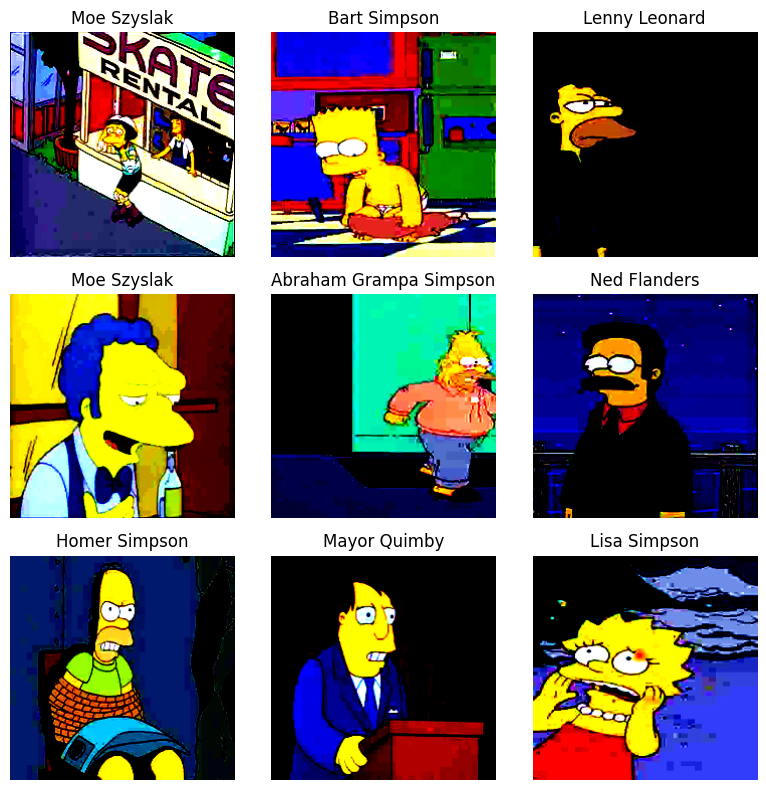

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Функция для отображения изображения
def imshow(image, title, plt_ax):
    plt_ax.imshow(image.permute(1, 2, 0))  # Изменяем размерность для правильного отображения
    plt_ax.set_title(title)
    plt_ax.axis('off')  # Убираем оси

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))  # Используйте длину вашего датасета
    im_val, label = val_dataset[random_characters]
    
    img_label = " ".join(map(lambda x: x.capitalize(),
                              val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

plt.tight_layout()  # Делаем так, чтобы элементы не накладывались
plt.show()

### Построение нейросети

In [20]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [23]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    
    log_template = (
        "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} "
        "val_loss: {v_loss:0.4f} train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f}"
    )

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()

            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [24]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [25]:
n_classes = len(np.unique(train_val_labels))

model = models.resnet50(weights="IMAGENET1K_V2")

model.fc = nn.Linear(2048, n_classes)
model = model.to(DEVICE)

Запустим обучение сети.

In [26]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [27]:
history = train(train_dataset, val_dataset, model=model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

epoch:  10%|███████▌                                                                   | 1/10 [03:38<32:45, 218.36s/it]


Epoch 001 train_loss: 0.6279 val_loss: 0.2632 train_acc: 0.8492 val_acc: 0.9318


epoch:  20%|███████████████                                                            | 2/10 [07:15<29:00, 217.58s/it]


Epoch 002 train_loss: 0.1696 val_loss: 0.2528 train_acc: 0.9576 val_acc: 0.9370


epoch:  30%|██████████████████████▌                                                    | 3/10 [10:51<25:19, 217.05s/it]


Epoch 003 train_loss: 0.0920 val_loss: 0.2093 train_acc: 0.9751 val_acc: 0.9457


epoch:  40%|██████████████████████████████                                             | 4/10 [14:28<21:41, 216.85s/it]


Epoch 004 train_loss: 0.0775 val_loss: 0.2300 train_acc: 0.9794 val_acc: 0.9427


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [18:11<18:15, 219.06s/it]


Epoch 005 train_loss: 0.0219 val_loss: 0.1200 train_acc: 0.9952 val_acc: 0.9731


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [21:57<14:46, 221.54s/it]


Epoch 006 train_loss: 0.0051 val_loss: 0.1139 train_acc: 0.9994 val_acc: 0.9757


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [25:43<11:09, 223.08s/it]


Epoch 007 train_loss: 0.0030 val_loss: 0.1119 train_acc: 0.9999 val_acc: 0.9761


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [29:31<07:28, 224.45s/it]


Epoch 008 train_loss: 0.0020 val_loss: 0.1124 train_acc: 0.9999 val_acc: 0.9759


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [33:17<03:45, 225.11s/it]


Epoch 009 train_loss: 0.0015 val_loss: 0.1113 train_acc: 0.9999 val_acc: 0.9761


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [37:19<00:00, 223.94s/it]


Epoch 010 train_loss: 0.0015 val_loss: 0.1111 train_acc: 0.9999 val_acc: 0.9761


Построим кривые обучения

In [28]:
loss, acc, val_loss, val_acc = zip(*history)

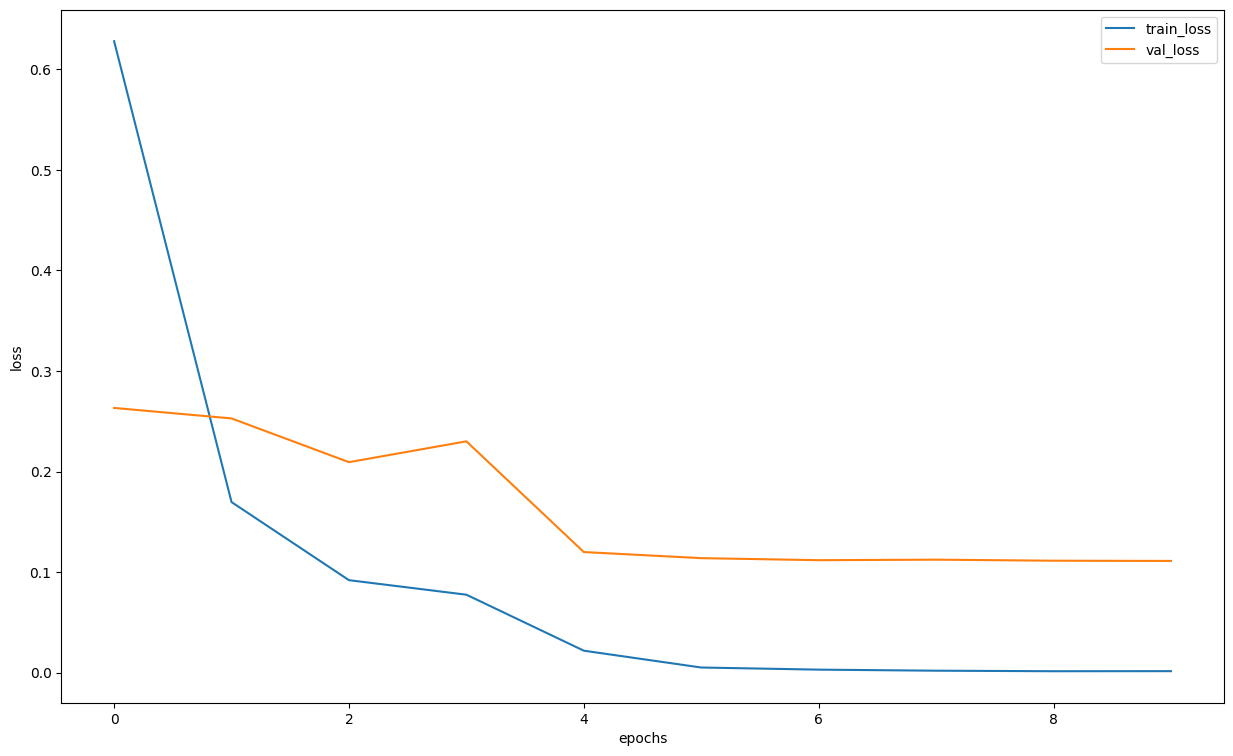

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [32]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [34]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [35]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


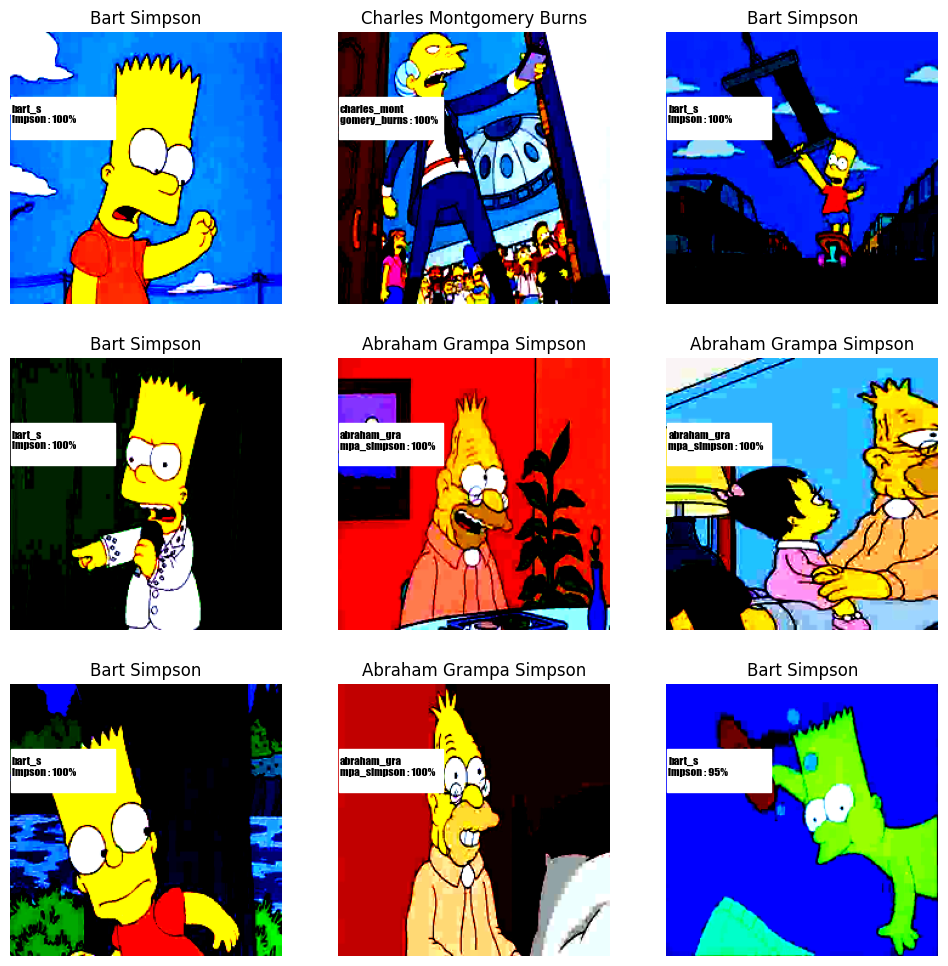

In [36]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Предобученная модель ResNet

Training: 100%|█| 123/123 [05:15<00:00,  2.56s/batch, acc=tensor(0.8564, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:22<00:00,  1.81batch/s, acc=tensor(0.9247, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 1/10 - Train Loss: 0.6183, Train Acc: 0.8564, Val Loss: 0.2832, Val Acc: 0.9247


Training: 100%|█| 123/123 [04:58<00:00,  2.43s/batch, acc=tensor(0.9601, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.01batch/s, acc=tensor(0.9358, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 2/10 - Train Loss: 0.1555, Train Acc: 0.9601, Val Loss: 0.2549, Val Acc: 0.9358


Training: 100%|█| 123/123 [04:58<00:00,  2.43s/batch, acc=tensor(0.9740, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.02batch/s, acc=tensor(0.9005, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 3/10 - Train Loss: 0.0956, Train Acc: 0.9740, Val Loss: 0.3966, Val Acc: 0.9005


Training: 100%|█| 123/123 [04:58<00:00,  2.43s/batch, acc=tensor(0.9808, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.01batch/s, acc=tensor(0.9498, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 4/10 - Train Loss: 0.0751, Train Acc: 0.9808, Val Loss: 0.2066, Val Acc: 0.9498


Training: 100%|█| 123/123 [05:02<00:00,  2.46s/batch, acc=tensor(0.9957, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.00batch/s, acc=tensor(0.9744, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 5/10 - Train Loss: 0.0187, Train Acc: 0.9957, Val Loss: 0.1061, Val Acc: 0.9744


Training: 100%|█| 123/123 [04:58<00:00,  2.43s/batch, acc=tensor(0.9994, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.01batch/s, acc=tensor(0.9763, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 6/10 - Train Loss: 0.0058, Train Acc: 0.9994, Val Loss: 0.1026, Val Acc: 0.9763


Training: 100%|█| 123/123 [04:59<00:00,  2.44s/batch, acc=tensor(0.9995, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:21<00:00,  1.91batch/s, acc=tensor(0.9767, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 7/10 - Train Loss: 0.0034, Train Acc: 0.9995, Val Loss: 0.1033, Val Acc: 0.9767


Training: 100%|█| 123/123 [05:17<00:00,  2.58s/batch, acc=tensor(0.9997, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.05batch/s, acc=tensor(0.9771, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 8/10 - Train Loss: 0.0023, Train Acc: 0.9997, Val Loss: 0.1033, Val Acc: 0.9771


Training: 100%|█| 123/123 [05:00<00:00,  2.45s/batch, acc=tensor(0.9997, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  2.02batch/s, acc=tensor(0.9782, device='cuda:0', dtype=torch.float64), loss=0.


Epoch 9/10 - Train Loss: 0.0018, Train Acc: 0.9997, Val Loss: 0.1018, Val Acc: 0.9782


Training: 100%|█| 123/123 [04:58<00:00,  2.43s/batch, acc=tensor(0.9998, device='cuda:0', dtype=torch.float64), loss=0.
Validation: 100%|█| 41/41 [00:20<00:00,  1.96batch/s, acc=tensor(0.9773, device='cuda:0', dtype=torch.float64), loss=0.

Epoch 10/10 - Train Loss: 0.0017, Train Acc: 0.9998, Val Loss: 0.1017, Val Acc: 0.9773


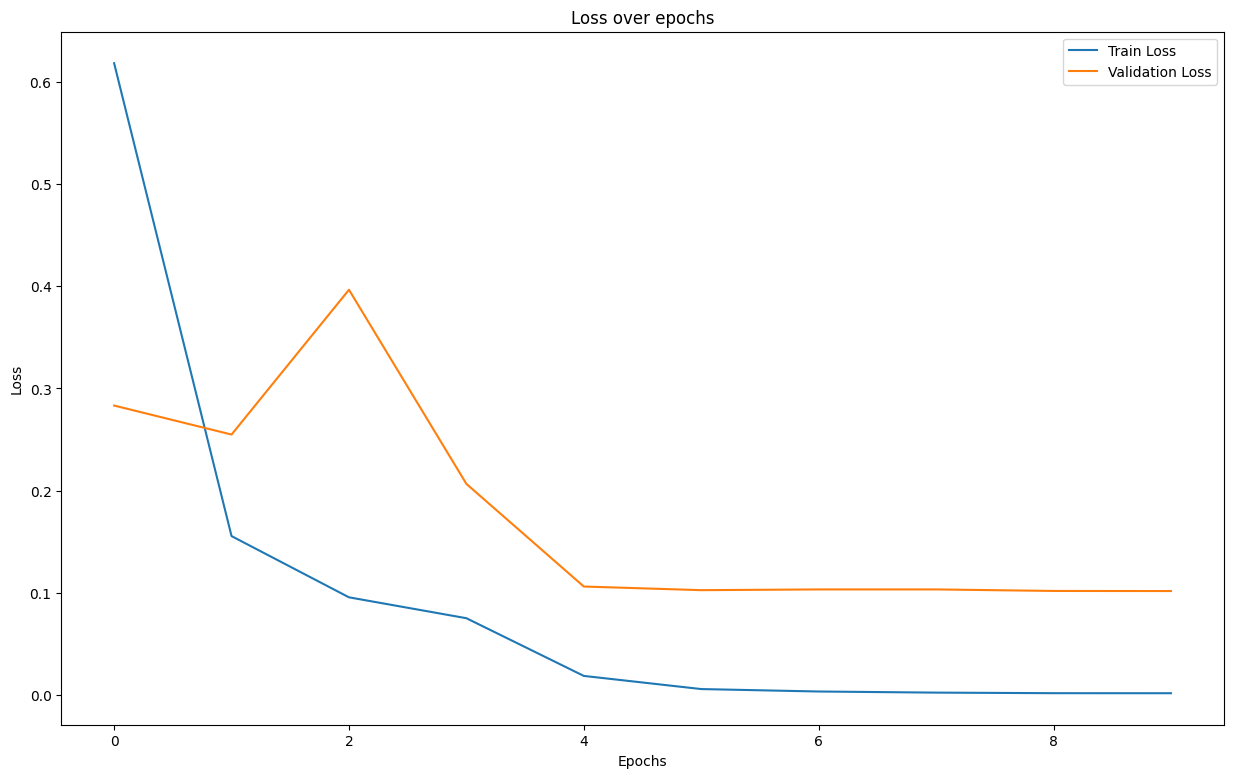

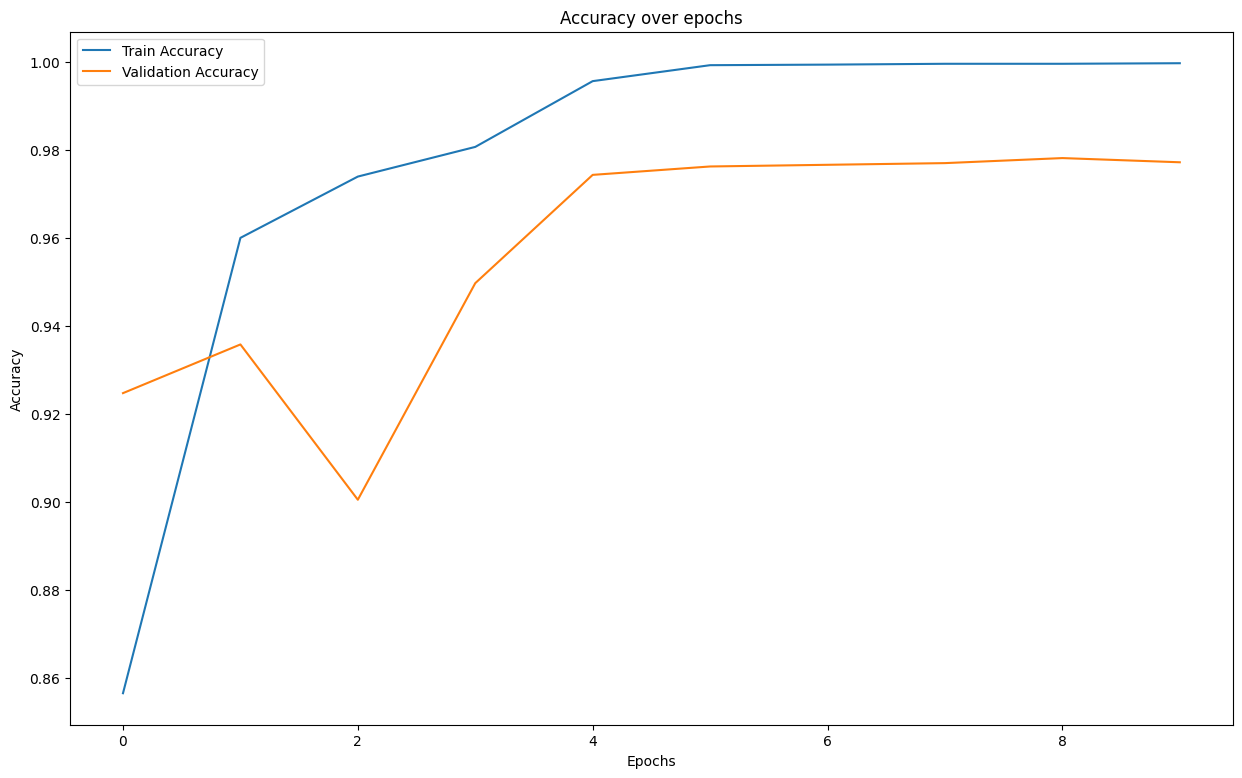

F1 Score: 0.9773


In [16]:
import os
import random
import numpy as np
import pickle
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Установка устройства для работы – GPU, если доступно
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Установка seed для воспроизводимости
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(2025)

# Параметры
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
RESCALE_SIZE = 224

# Класс для загрузки данных
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in ['train', 'val', 'test']:
            raise ValueError(f"{self.mode} is not a valid mode")

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

# Загрузка данных
TRAIN_DIR = Path('train/')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

# Создание объектов датасета
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

# Функция для обучения модели
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    with tqdm(train_loader, desc="Training", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)

            pbar.set_postfix(loss=running_loss / processed_data, acc=running_corrects.double() / processed_data)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.double() / processed_data
    return train_loss, train_acc

# Функция для валидации модели
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    with torch.no_grad():
        with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                processed_size += inputs.size(0)

                pbar.set_postfix(loss=running_loss / processed_size, acc=running_corrects.double() / processed_size)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

# Функция для обучения всей модели
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
        scheduler.step()

        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc.item(), val_loss, val_acc.item()))

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return history

# Подготовка модели
n_classes = len(np.unique(train_val_labels))
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(2048, n_classes)
model = model.to(DEVICE)

# Обучение модели
history = train(train_dataset, val_dataset, model=model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

# Визуализация результатов
loss, train_acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Получение предсказаний на валидационном наборе и вычисление F1-метрики
def get_val_predictions(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

# Вычисление F1-метрики
y_true, y_pred = get_val_predictions(model, val_loader)
f1 = f1_score(y_true, y_pred, average='micro')
print(f"F1 Score: {f1:.4f}")

# Сохранение метрик
metrics = {
    'train_loss': loss[-1],
    'train_accuracy': train_acc[-1],
    'val_loss': val_loss[-1],
    'val_accuracy': val_acc[-1],
    'f1_score': f1,
}

with open('model/metrics.pkl', 'wb') as metrics_file:
    pickle.dump(metrics, metrics_file)

### F1-оценка: 0.95 улучшилась до F1 Score: 0.9773

### Проект FastAPI

### Описание

Проект реализован с интерфейсом на **FastAPI** и размещен на GitHub.

### Технологии

- **FastAPI** - фреймворк для создания API
- **GitHub** - платформа для хостинга кода

### Статус

Проект завершен и размещен в репозитории GitHub.